In [1]:
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version은 코랩 명령입니다.
    %tensorflow_version 2.x
except Exception:
    pass

# 텐서플로 ≥2.0 필수
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)
tf.random.set_seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# ﻿Chapter 12. 텐서플로를 사용한 사용자 정의 모델과 훈련﻿

## 12.1 텐서플로 훑어보기

### 12.2.1 텐서와 연산

In [3]:
#두 개의 행과 세 개의 열을 가진 실수 행렬을 나타내는 텐서
tf.constant([[1., 2., 3.] , [4., 5., 6.,]])

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [4]:
#스칼라
tf.constant(42)

<tf.Tensor: shape=(), dtype=int32, numpy=42>

In [5]:
t = tf.constant([[1., 2., 3.] , [4., 5., 6.,]])
print(t.shape)
print(t.dtype)

(2, 3)
<dtype: 'float32'>


﻿인덱스 참조도 넘파이와 매우 비슷하게 작동한다.

In [6]:
t[:, 1:]

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[2., 3.],
       [5., 6.]], dtype=float32)>

In [7]:
t[..., 1, tf.newaxis]

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[2.],
       [5.]], dtype=float32)>

﻿모든 종류의 텐서 연산이 가능하다.

In [8]:
#tf.add(t, 10)
t + 10

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[11., 12., 13.],
       [14., 15., 16.]], dtype=float32)>

In [9]:
tf.square(t)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[ 1.,  4.,  9.],
       [16., 25., 36.]], dtype=float32)>

In [10]:
t @ tf.transpose(t)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[14., 32.],
       [32., 77.]], dtype=float32)>

저수준 API

In [11]:
from tensorflow import keras
K = keras.backend
K.square(K.transpose(t)) + 10

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[11., 26.],
       [14., 35.],
       [19., 46.]], dtype=float32)>

### 12.2.2 텐서와 넘파이

In [12]:
a = np.array([2., 4., 5.])
tf.constant(a)

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([2., 4., 5.])>

In [13]:
t.numpy()

array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)

In [14]:
tf.square(a)

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([ 4., 16., 25.])>

In [15]:
tf.square(a)

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([ 4., 16., 25.])>

In [16]:
np.square(t)

array([[ 1.,  4.,  9.],
       [16., 25., 36.]], dtype=float32)

### 12.2.3 타입 변환

In [17]:
tf.constant(2.) + tf.constant(40)

InvalidArgumentError: ignored

In [18]:
tf.constant(2.) + tf.constant(40., dtype=tf.float64)

InvalidArgumentError: ignored

### 12.2.4 변수

In [19]:
v = tf.Variable([[1., 2., 3.], [4., 5., 6.]])
v

<tf.Variable 'Variable:0' shape=(2, 3) dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [20]:
# v.assign(2 * v)
# v[0, 1].assign(42)
# v[:, 2].assign([0., 1.])
v.scatter_nd_update(indices=[[0, 0], [1, 2]], updates=[100., 200.])

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[100.,   2.,   3.],
       [  4.,   5., 200.]], dtype=float32)>

## 12.3 사용자 정의 모델과 훈련 알고리즘

### 12.3.1 사용자 정의 손실 함수

In [21]:
#Huber Loss Function
def huber_fn(y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < 1
    squared_loss = tf.square(error) / 2
    linear_loss = tf.abs(error) - 0.5
    return tf.where(is_small_error, squared_loss, linear_loss)

In [22]:
#캘리포니아 주택 데이터 셋
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

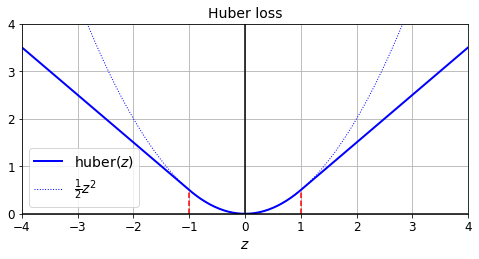

In [23]:
plt.figure(figsize=(8, 3.5))
z = np.linspace(-4, 4, 200)
plt.plot(z, huber_fn(0, z), "b-", linewidth=2, label="huber($z$)")
plt.plot(z, z**2 / 2, "b:", linewidth=1, label=r"$\frac{1}{2}z^2$")
plt.plot([-1, -1], [0, huber_fn(0., -1.)], "r--")
plt.plot([1, 1], [0, huber_fn(0., 1.)], "r--")
plt.gca().axhline(y=0, color='k')
plt.gca().axvline(x=0, color='k')
plt.axis([-4, 4, 0, 4])
plt.grid(True)
plt.xlabel("$z$")
plt.legend(fontsize=14)
plt.title("Huber loss", fontsize=14)
plt.show()

In [24]:
input_shape = X_train.shape[1:]

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [25]:
model.compile(loss=huber_fn, optimizer="nadam", metrics=["mae"])

In [26]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 2s 2ms/step - loss: 0.6235 - mae: 0.9953 - val_loss: 0.2862 - val_mae: 0.5866
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2197 - mae: 0.5177 - val_loss: 0.2382 - val_mae: 0.5281


### ﻿12.3.2 사용자 정의 요소를 가진 모델을 저장하고 로드하기

In [27]:
model.save("images/my_model_with_a_custom_loss.h5")

In [28]:
model = keras.models.load_model("images/my_model_with_a_custom_loss.h5",
                               custom_objects = {"huber_fn" : huber_fn})

In [32]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2750 - mae: 0.4838 - val_loss: 0.3146 - val_mae: 0.4907
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2713 - mae: 0.4776 - val_loss: 0.2916 - val_mae: 0.4800


In [33]:
def create_huber(threshold = 1.0):
    def huber_fn(y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < threshold
        squared_loss = tf.abs(error) / 2
        linear_loss = threshold * tf.abs(error) - threshold **2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    return huber_fn

In [34]:
model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=["mae"])

In [35]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2686 - mae: 0.4736 - val_loss: 0.2912 - val_mae: 0.4753
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2660 - mae: 0.4698 - val_loss: 0.2688 - val_mae: 0.4651


In [36]:
# 위와같은 문제는 keras.losses.Loss 클래스를 상속하고, get_config() 메서드를 구현하여 해결
class HuberLoss(keras.losses.Loss):
    def __init__(self, threshold = 1.0, **kwargs):
        self.threshold = threshold
        super().__init__(**kwargs)
    def call(self, y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < self.threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = self.threshold * tf.abs(error) - self.threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}
        

### 12.3.3 활성화 함수, 초기화 규제, 제한을 커스터마이징하기

In [37]:
#사용자 정의 활성화 함수
def my_softplus(z):
    return tf.math.log(tf.exp(z) + 1.0)

#사용자 정의 글로럿 초기화
def my_glorot_initializer(shape, dtype = tf.float32):
    stddev = tf.sqrt(2. / (shape[0] + shape[1]))
    return tf.random.normal(shape, stddev = stddev, dtype =dtype)

#사용자 정의 ℓ1 규제
def my_l1_regularizer(weights):
    return tf.reduce_sum(tf.abs(0.01 * weights))

#양수인 가중치만 남기는 사용자 정의 제한
def my_positive_weights(weights): # tf.nn.relu(weights) 값을 반환합니다
    return tf.where(weights < 0., tf.zeros_like(weights), weights)

In [38]:
layer = keras.layers.Dense(1, activation=my_softplus,
                           kernel_initializer=my_glorot_initializer,
                           kernel_regularizer=my_l1_regularizer,
                           kernel_constraint=my_positive_weights)

In [39]:
# 활성화 함수는 Dense 층의 출력에 적용되고 다음 층에 그 결과가 전달
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1, activation=my_softplus,
                       kernel_regularizer=my_l1_regularizer,
                       kernel_constraint=my_positive_weights,
                       kernel_initializer=my_glorot_initializer),
])

In [40]:
model.compile(loss="mse", optimizer="nadam", metrics=["mae"])

In [41]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 1.5901 - mae: 0.8871 - val_loss: 1.4671 - val_mae: 0.5719
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.6168 - mae: 0.5327 - val_loss: 1.3017 - val_mae: 0.5177


In [42]:
model.save("model/my_model_with_many_custom_parts.h5")

In [43]:
model = keras.models.load_model(
    "model/my_model_with_many_custom_parts.h5",
    custom_objects={
       "my_l1_regularizer": my_l1_regularizer,
       "my_positive_weights": my_positive_weights,
       "my_glorot_initializer": my_glorot_initializer,
       "my_softplus": my_softplus,
    })

In [44]:
#factor 하이퍼파라미터를 저장하는 ℓ1규제를 위한 간단한 클래스
class MyL1Regularizer(keras.regularizers.Regularizer):
    def __init__(self, factor):
        self.factor = factor
    def __call__(self, weights):
        return tf.reduce_sum(tf.abs(self.factor * weights))
    def get_config(self):
        return {"factor" : self.factor}

In [45]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1, activation=my_softplus,
                       kernel_regularizer=MyL1Regularizer(0.01),
                       kernel_constraint=my_positive_weights,
                       kernel_initializer=my_glorot_initializer),
])

In [46]:
model.compile(loss="mse", optimizer="nadam", metrics=["mae"])

In [47]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 2.1606 - mae: 0.9112 - val_loss: inf - val_mae: inf
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 1.0011 - mae: 0.5538 - val_loss: inf - val_mae: inf


### 12.3.4 사용자 정의 지표

In [48]:
precision = keras.metrics.Precision()
precision([0, 1, 1, 1, 0, 1, 0, 1], [1, 1, 0, 1, 0, 1, 0, 1])

<tf.Tensor: shape=(), dtype=float32, numpy=0.8>

In [49]:
precision([0, 1, 0, 0, 1, 0, 1, 1], [1, 0, 1, 1, 0, 0, 0, 0])

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

In [50]:
precision.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

In [51]:
precision.variables

[<tf.Variable 'true_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>,
 <tf.Variable 'false_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>]

In [52]:
precision.reset_states()

전체 후버 손실과 지금까지 처리한 샘플 수를 기록하는 클래스

In [53]:
class HuberMetric(keras.metrics.Metric):
    def __init__(self, threshold=1.0, **kwargs):
        super().__init__(**kwargs)
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        self.total = self.add_weight("total", initializer = "zeros")
        self.count = self.add_weight("count", initializer = "zeros")
    def update_state(self, y_true, y_pred, sample_weight = None):
        metric = self.huber_fn(y_true, y_pred)
        self.total.assign_add(tf.reduce_sum(metric))
        self.count.assign_add(tf.cast(tf.size(y_true), tf.float32))
    def result(self):
        return self.total / self.count
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold" : self.threshold}
        

### 12.3.5 사용자 정의 층

In [54]:
# 가중치가 필요없는 사용자 정의 층을 만들기 위한 간단한 방법은 keras.layers.Lambda층으로 감싸는 것
exponential_layer = keras.layers.Lambda(lambda x : tf.exp(x))

In [55]:
exponential_layer([-1., 0., 1.,])

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.36787945, 1.        , 2.7182817 ], dtype=float32)>

In [56]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=input_shape),
    keras.layers.Dense(1),
    exponential_layer
])
model.compile(loss="mse", optimizer="nadam")
model.fit(X_train_scaled, y_train, epochs=5,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/5
363/363 [==============================] - 1s 2ms/step - loss: 0.8441 - val_loss: 0.4838
Epoch 2/5
363/363 [==============================] - 1s 2ms/step - loss: 0.4706 - val_loss: 0.3930
Epoch 3/5
363/363 [==============================] - 1s 2ms/step - loss: 0.4122 - val_loss: 0.3630
Epoch 4/5
363/363 [==============================] - 1s 2ms/step - loss: 0.3917 - val_loss: 0.3817
Epoch 5/5
162/162 [==============================] - 0s 1ms/step - loss: 0.3807


0.3806864023208618

In [57]:
# 두 개의 입력과 세 개의 출력을 만드는 층
class MyMultiLayer(keras.layers.Layer):
    def call(self, X):
        X1, X2 = X
        return [X1 + X2, X1 * X2, X1 / X2]
    
    def comput_output_shape(self, batch_input_shape):
        b1, b2 = batch_input_shape
        return [b1, b2, b1]

In [58]:
#예시로 훈련하는 동안 가우스 잡음을 추가하고 테스트 시에는 아무것도 하지 않는 층
class AddGaussianNoise(keras.layers.Layer):
    def __init__(self, stddev, **kwargs):
        super().__init__(**kwargs)
        self.stddev = stddev

    def call(self, X, training=None):
        if training:
            noise = tf.random.normal(tf.shape(X), stddev=self.stddev)
            return X + noise
        else:
            return X

    def compute_output_shape(self, batch_input_shape):
        return batch_input_shape
    
# 이 예시와 같은 케라스 층 : keras.layers,GaussianNoise

### 12.3.6 사용자 정의 모델

In [59]:
class ResidualBlock(keras.layers.Layer):
    def __init__(self, n_layers, n_neurons, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [keras.layers.Dense(n_neurons, activation="elu", kernel_initializer = "he_normal")
                      for _ in range(n_layers)]
    def call(self, inputs):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        return inputs + Z

In [60]:
#케라스가 알아서 추적해야 할 객체가 담긴 hidden속성을 감지하고 필요한 변수를 자동으로 이 층의 변수 리스트에 추가
class ResidualRegressor(keras.models.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(30, activation="elu",
                                          kernel_initializer="he_normal")
        self.block1 = ResidualBlock(2, 30)
        self.block2 = ResidualBlock(2, 30)
        self.out = keras.layers.Dense(output_dim)

    def call(self, inputs):
        Z = self.hidden1(inputs)
        for _ in range(1 + 3):
            Z = self.block1(Z)
        Z = self.block2(Z)
        return self.out(Z)

In [61]:
model = ResidualRegressor(1)
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=5)
score = model.evaluate(X_test_scaled, y_test)
y_pred = model.predict(X_new_scaled)

Epoch 1/5
363/363 [==============================] - 2s 2ms/step - loss: 7.5208
Epoch 2/5
363/363 [==============================] - 1s 2ms/step - loss: 1.2421
Epoch 3/5
363/363 [==============================] - 1s 2ms/step - loss: 0.8729
Epoch 4/5
363/363 [==============================] - 1s 2ms/step - loss: 0.6376
Epoch 5/5
162/162 [==============================] - 0s 1ms/step - loss: 2.3008


NameError: ignored

In [66]:
model.save("model/my_custom_model.ckpt")

INFO:tensorflow:Assets written to: model/my_custom_model.ckpt/assets


INFO:tensorflow:Assets written to: model/my_custom_model.ckpt/assets


In [67]:
#대신 시퀀셜 API를 사용하는 모델을 정의
block1 = ResidualBlock(2, 30)
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="elu", kernel_initializer="he_normal"),
    block1, block1, block1, block1,
    ResidualBlock(2, 30),
    keras.layers.Dense(1)
])

In [68]:
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=5)
score = model.evaluate(X_test_scaled, y_test)
y_pred = model.predict(X_new_scaled)

Epoch 1/5
363/363 [==============================] - 2s 2ms/step - loss: 1.1314
Epoch 2/5
363/363 [==============================] - 1s 2ms/step - loss: 0.6229
Epoch 3/5
363/363 [==============================] - 1s 2ms/step - loss: 0.5177
Epoch 4/5
363/363 [==============================] - 1s 2ms/step - loss: 0.4679
Epoch 5/5
162/162 [==============================] - 0s 1ms/step - loss: 0.3527


NameError: ignored

### 12.3.7 모델 구성 요소에 기반한 손실과 지표

In [ ]:
class ReconstructingRegressor(keras.models.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [keras.layers.Dense(30, activation="selu",
                                          kernel_initializer="lecun_normal")
                       for _ in range(5)]
        self.out = keras.layers.Dense(output_dim)

    def build(self, batch_input_shape):
        n_inputs = batch_input_shape[-1]
        self.reconstruct = keras.layers.Dense(n_inputs, name='recon')
        super().build(batch_input_shape)

    def call(self, inputs, training=None):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        reconstruction = self.reconstruct(Z)
        self.recon_loss = 0.05 * tf.reduce_mean(tf.square(reconstruction - inputs))
        return self.out(Z)
    
    def train_step(self, data):
        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x)
            loss = self.compiled_loss(y, y_pred, regularization_losses=[self.recon_loss])

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        return {m.name: m.result() for m in self.metrics}

In [ ]:
model = ReconstructingRegressor(1)
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=2)
y_pred = model.predict(X_test_scaled)

### 12.3.8 자동 미분 사용하여 그레이디언트 계산하기

In [69]:
def f(w1, w2):
    return 3*w1**2 + 2*w1 * w2

In [70]:
w1, w2 = 5, 3
eps = 1e-6
(f(w1 + eps, w2) - f(w1, w2)) / eps

36.000003007075065

In [71]:
(f(w1, w2+eps) - f(w1, w2)) / eps 

10.000000003174137

In [72]:
#텐서플로의 자동 미분
w1, w2 = tf.Variable(5.), tf.Variable(3.)
with tf.GradientTape() as tape:
    z = f(w1, w2)
gradients = tape.gradient(z, [w1, w2])
gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

In [73]:
# gradient() 메서드가 호출된 후에는 자동으로 테이프가 지워지므로, 두번 호출하면 예외가 발생한다.
with tf.GradientTape() as tape:
    z = f(w1, w2)
dz_dw1 = tape.gradient(z, w1)
dz_dw2 = tape.gradient(z, w2)

RuntimeError: ignored

In [74]:
#리소스 해제
with tf.GradientTape(persistent=True) as tape:
    z = f(w1, w2)

dz_dw1 = tape.gradient(z, w1)
dz_dw2 = tape.gradient(z, w2) # works now!
del tape

In [75]:
dz_dw1, dz_dw2

(<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>)

In [76]:
#변수가 아닌 다른 객체에 대한 z의 그레이디언트
c1, c2 = tf.constant(5.), tf.constant(3.)
with tf.GradientTape() as tape:
    z = f(c1, c2)

gradients = tape.gradient(z, [c1, c2])
gradients

[None, None]

In [77]:
#모든 연산을 기록하도록 강제
with tf.GradientTape() as tape:
    tape.watch(c1)
    tape.watch(c2)
    z = f(c1, c2)

gradients = tape.gradient(z, [c1, c2])
gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

In [78]:
def f(w1, w2):
    return 3 * w1 ** 2 + tf.stop_gradient(2 * w1 * w2)

with tf.GradientTape() as tape:
    z = f(w1, w2)

tape.gradient(z, [w1, w2])

[<tf.Tensor: shape=(), dtype=float32, numpy=30.0>, None]

In [79]:
x = tf.Variable(100.)
with tf.GradientTape() as tape:
    z = my_softplus(x)

tape.gradient(z, [x])

[<tf.Tensor: shape=(), dtype=float32, numpy=nan>]

In [80]:
@tf.custom_gradient
def my_better_softplus(z):
    exp = tf.exp(z)
    def my_softplus_gradients(grad):
        return grad / (1 + 1 / exp)
    return tf.math.log(exp + 1), my_softplus_gradients

### 12.3.9 사용자 정의 훈련 반복

In [81]:
#훈련 반복을 직접 다루기 때문에 컴파일 할 필요가 없다.
l2_reg = keras.regularizers.l2(0.05)
model = keras.models.Sequential([
    keras.layers.Dense(30, activation = "elu", kernel_initializer = "he_normal",
                      kernel_regularizer = l2_reg),
    keras.layers.Dense(1, kernel_regularizer = l2_reg)
])

In [82]:
#훈련 세트에서 샘플 배치를 랜덤하게 추출하는 작은 함수
def random_batch(X, y, batch_size=32):
    idx = np.random.randint(len(X), size=batch_size)
    return X[idx], y[idx]

In [83]:
#현재 스텝 수, 전체 스텝 횟수, 에포크 시작부터 평균 손실 등 다른 지표를 포함하여 훈련 상태를 출력하는 함수
def print_status_bar(iteration, total, loss, metrics=None):
    metrics = " - ".join(["{}: {:.4f}".format(m.name, m.result())
                         for m in [loss] + (metrics or [])])
    end = "" if iteration < total else "\n"
    print("\r{}/{} - ".format(iteration, total) + metrics, end=end)

In [84]:
import time

mean_loss = keras.metrics.Mean(name="loss")
mean_square = keras.metrics.Mean(name="mean_square")
for i in range(1, 50 + 1):
    loss = 1 / i
    mean_loss(loss)
    mean_square(i ** 2)
    print_status_bar(i, 50, mean_loss, [mean_square])
    time.sleep(0.05)

50/50 - loss: 0.0900 - mean_square: 858.5000


In [85]:
#A fancier version with a progress bar:
def progress_bar(iteration, total, size=30):
    running = iteration < total
    c = ">" if running else "="
    p = (size - 1) * iteration // total
    fmt = "{{:-{}d}}/{{}} [{{}}]".format(len(str(total)))
    params = [iteration, total, "=" * p + c + "." * (size - p - 1)]
    return fmt.format(*params)

In [86]:
progress_bar(3500, 10000, size=6)

' 3500/10000 [=>....]'

In [87]:
def print_status_bar(iteration, total, loss, metrics=None, size=30):
    metrics = " - ".join(["{}: {:.4f}".format(m.name, m.result())
                         for m in [loss] + (metrics or [])])
    end = "" if iteration < total else "\n"
    print("\r{} - {}".format(progress_bar(iteration, total), metrics), end=end)

In [88]:
mean_loss = keras.metrics.Mean(name="loss")
mean_square = keras.metrics.Mean(name="mean_square")
for i in range(1, 50 + 1):
    loss = 1 / i
    mean_loss(loss)
    mean_square(i ** 2)
    print_status_bar(i, 50, mean_loss, [mean_square])
    time.sleep(0.05)

50/50 [==============================] - loss: 0.0900 - mean_square: 858.5000


In [89]:
n_epochs = 5
batch_size = 32
n_steps = len(X_train) // batch_size
optimizer = keras.optimizers.Nadam(lr=0.01)
loss_fn = keras.losses.mean_squared_error
mean_loss = keras.metrics.Mean()
metrics = [keras.metrics.MeanAbsoluteError()]

In [90]:
for epoch in range(1, n_epochs + 1):
    print("Epoch {}/{}".format(epoch, n_epochs))
    for step in range(1, n_steps + 1):
        X_batch, y_batch = random_batch(X_train_scaled, y_train)
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        for variable in model.variables:
            if variable.constraint is not None:
                variable.assign(variable.constraint(variable))
        mean_loss(loss)
        for metric in metrics:
            metric(y_batch, y_pred)
        print_status_bar(step * batch_size, len(y_train), mean_loss, metrics)
    print_status_bar(len(y_train), len(y_train), mean_loss, metrics)
    for metric in [mean_loss] + metrics:
        metric.reset_states()

Epoch 1/5
11610/11610 [==============================] - mean: 1.6406 - mean_absolute_error: 0.5848
Epoch 2/5
11610/11610 [==============================] - mean: 0.6822 - mean_absolute_error: 0.5273
Epoch 3/5
11610/11610 [==============================] - mean: 0.6355 - mean_absolute_error: 0.5196
Epoch 4/5
11610/11610 [==============================] - mean: 0.6395 - mean_absolute_error: 0.5200
Epoch 5/5
11610/11610 [==============================] - mean: 0.6455 - mean_absolute_error: 0.5237


In [91]:
try:
    from tqdm.notebook import trange
    from collections import OrderedDict
    with trange(1, n_epochs + 1, desc="All epochs") as epochs:
        for epoch in epochs:
            with trange(1, n_steps + 1, desc="Epoch {}/{}".format(epoch, n_epochs)) as steps:
                for step in steps:
                    X_batch, y_batch = random_batch(X_train_scaled, y_train)
                    with tf.GradientTape() as tape:
                        y_pred = model(X_batch)
                        main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
                        loss = tf.add_n([main_loss] + model.losses)
                    gradients = tape.gradient(loss, model.trainable_variables)
                    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
                    for variable in model.variables:
                        if variable.constraint is not None:
                            variable.assign(variable.constraint(variable))                    
                    status = OrderedDict()
                    mean_loss(loss)
                    status["loss"] = mean_loss.result().numpy()
                    for metric in metrics:
                        metric(y_batch, y_pred)
                        status[metric.name] = metric.result().numpy()
                    steps.set_postfix(status)
            for metric in [mean_loss] + metrics:
                metric.reset_states()
except ImportError as ex:
    print("To run this cell, please install tqdm, ipywidgets and restart Jupyter")

All epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|          | 0/362 [00:00<?, ?it/s]

Epoch 2/5:   0%|          | 0/362 [00:00<?, ?it/s]

Epoch 3/5:   0%|          | 0/362 [00:00<?, ?it/s]

Epoch 4/5:   0%|          | 0/362 [00:00<?, ?it/s]

Epoch 5/5:   0%|          | 0/362 [00:00<?, ?it/s]

## 12.4 텐서플로 함수와 그래프

In [92]:
#세 제곱을 계산하는 함수
def cube(x):
    return x**3

In [93]:
cube(2)

8

In [94]:
cube(tf.constant(2.0))

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

In [95]:
tf_cube = tf.function(cube)
tf_cube

In [96]:
tf_cube(2)

<tf.Tensor: shape=(), dtype=int32, numpy=8>

In [97]:
tf_cube(tf.constant(2.0))

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

In [98]:
#tf.function 데코레이터
@tf.function
def tf_cube(x):
    return x ** 3

In [99]:
tf_cube.python_function(2)

8

### 12.4.1 오토그래프와 트레이싱

In [100]:
#for 문
@tf.function
def add_10(x):
    for i in range(10):
        x += 1
    return x

In [101]:
add_10(tf.constant(5))

<tf.Tensor: shape=(), dtype=int32, numpy=15>

In [102]:
add_10.get_concrete_function(tf.constant(5)).graph.get_operations()

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'add/y' type=Const>,
 <tf.Operation 'add' type=AddV2>,
 <tf.Operation 'add_1/y' type=Const>,
 <tf.Operation 'add_1' type=AddV2>,
 <tf.Operation 'add_2/y' type=Const>,
 <tf.Operation 'add_2' type=AddV2>,
 <tf.Operation 'add_3/y' type=Const>,
 <tf.Operation 'add_3' type=AddV2>,
 <tf.Operation 'add_4/y' type=Const>,
 <tf.Operation 'add_4' type=AddV2>,
 <tf.Operation 'add_5/y' type=Const>,
 <tf.Operation 'add_5' type=AddV2>,
 <tf.Operation 'add_6/y' type=Const>,
 <tf.Operation 'add_6' type=AddV2>,
 <tf.Operation 'add_7/y' type=Const>,
 <tf.Operation 'add_7' type=AddV2>,
 <tf.Operation 'add_8/y' type=Const>,
 <tf.Operation 'add_8' type=AddV2>,
 <tf.Operation 'add_9/y' type=Const>,
 <tf.Operation 'add_9' type=AddV2>,
 <tf.Operation 'Identity' type=Identity>]

In [103]:
#while문
@tf.function
def add_10(x):
    condition = lambda i, x: tf.less(i, 10)
    body = lambda i, x: (tf.add(i, 1), tf.add(x, 1))
    final_i, final_x = tf.while_loop(condition, body, [tf.constant(0), x])
    return final_x

In [104]:
add_10(tf.constant(5))

<tf.Tensor: shape=(), dtype=int32, numpy=15>

In [105]:
add_10.get_concrete_function(tf.constant(5)).graph.get_operations()

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'Const' type=Const>,
 <tf.Operation 'while/maximum_iterations' type=Const>,
 <tf.Operation 'while/loop_counter' type=Const>,
 <tf.Operation 'while' type=StatelessWhile>,
 <tf.Operation 'Identity' type=Identity>]